In [46]:
import polyscope as ps
import trimesh
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image

ps.set_allow_headless_backends(True)  
ps.set_autocenter_structures(False)
ps.set_autoscale_structures(False)
ps.set_automatically_compute_scene_extents(False)
ps.set_window_size(800, 800)
ps.init()

ERROR_SCALE = 1e5
COLOR_REF = (0.6, 0.6, 0.6)
COLOR_OTHER = (0.7, 0.5, 0.2)
COLOR_OURS = (0.2, 0.5, 0.7)

In [36]:
def load_obj_vertices_faces(path):
    vertices = []
    faces = []
    with open(path, 'r') as f:
        for line in f:
            if line.startswith('v '):  # vertex
                parts = line.strip().split()
                vertices.append(tuple(map(float, parts[1:4])))
            elif line.startswith('f '):  # face
                parts = line.strip().split()[1:]
                # Keep original face structure (no triangulation)
                face = [int(p.split('/')[0]) - 1 for p in parts]
                faces.append(face)
    return vertices, faces

def rescale_hotspot(mesh_path):

    mesh = trimesh.load(mesh_path)

    # # Normalize mesh (centered and scaled uniformly)
    # bbox = mesh.bounds
    # center = mesh.centroid
    # scale = np.linalg.norm(bbox[1] - bbox[0])
    # mesh.apply_translation(-center)
    # mesh.apply_scale(1.0 / scale)

    # # Export normalized mesh
    # mesh.export(mesh_path.replace(".obj", ".obj"))

    points, _ = trimesh.sample.sample_surface(mesh, 100000)
    # center and scale point cloud
    cp = points.mean(axis=0)
    points = points - cp[None, :]
    scale = np.percentile(np.linalg.norm(points, axis=-1), 70) / 0.45
    scale = max(scale, np.abs(points).max())
    return scale

def obj2image(path, cam_position=np.array([1, -2, 0]), target=np.array([0, 0, 0]), fov=60, aspect=1.0, rescale=False, color=(0.2, 0.5, 0.7)):
    # Trimesh without triangulate
    vertices, faces = load_obj_vertices_faces(path)
    if rescale:
        scale = rescale_hotspot(path)
        vertices /= scale

    # Add [0, 0, 0.5] to vertices
    vertices += np.array([0, 0, -0.1])

    # TODO: See how to add shadows
    ps.set_ground_plane_mode("none")  # set +Z as up direction
    # ps.set_shadow_darkness(0.1)              # lighter shadows
    # ps.set_ground_height(0.) # in world coordinates

    ps.set_length_scale(1.)
    low = np.array((-1, -1, -1)) 
    high = np.array((1., 1., 1.)) 
    ps.set_bounding_box(low, high)


    # Make Z- orientation
    ps.set_up_dir("z_up")
    ps.set_front_dir("neg_y_front")
    # Change camera to orto
    ps.set_view_projection_mode("perspective")
    ps.set_length_scale(0.7)

    look_dir = target - cam_position
    look_dir /= np.linalg.norm(look_dir)  # Normalize the look direction

    intrinsics = ps.CameraIntrinsics(fov_vertical_deg=fov, aspect=aspect)
    extrinsics = ps.CameraExtrinsics(root=cam_position, look_dir=look_dir, up_dir=(0., 0., 1.))
    params = ps.CameraParameters(intrinsics, extrinsics)

    ps.set_view_camera_parameters(params)

    ps_mesh = ps.register_surface_mesh("mesh", vertices, faces, edge_width=1, back_face_policy="identical", smooth_shade=False, material='clay', color=color)
    img = ps.screenshot_to_buffer()
    return img

In [ ]:
import csv

def get_errors_from_csv(root):
    csv_path = f"{root}/metrics_final_obj_only.csv"

    errors_chamfer = {}
    errors_f1 = {}
    with open(csv_path, "r") as f:
        reader = csv.reader(f)
        headers = next(reader)
        for row in reader:
            d = dict(zip(headers, row))
            obj_name = root + d["folder"] + "/" + d["filename"]
            errors_chamfer[obj_name] = float(d["chamfer_distance_2"])
            errors_f1[obj_name] = float(d["f1_score"])
    return errors_chamfer, errors_f1

===== 16 ======
Voromesh FIGURE_CASE_441708/441708_b16/voromesh_16_final_DCCVT_cvt0_sdfsmooth0.obj
CD:7.903 | F1:0.472
MT FIGURE_CASE_441708/441708_b16/marching_tetrahedra_0_final_MT_cvt0_sdfsmooth0.obj
CD:17.14 | F1:0.239
Ours FIGURE_CASE_441708/441708_b16/DCCVT_0_final_intDCCVT_cvt100_sdfsmooth100.obj
CD:26.23 | F1:0.202


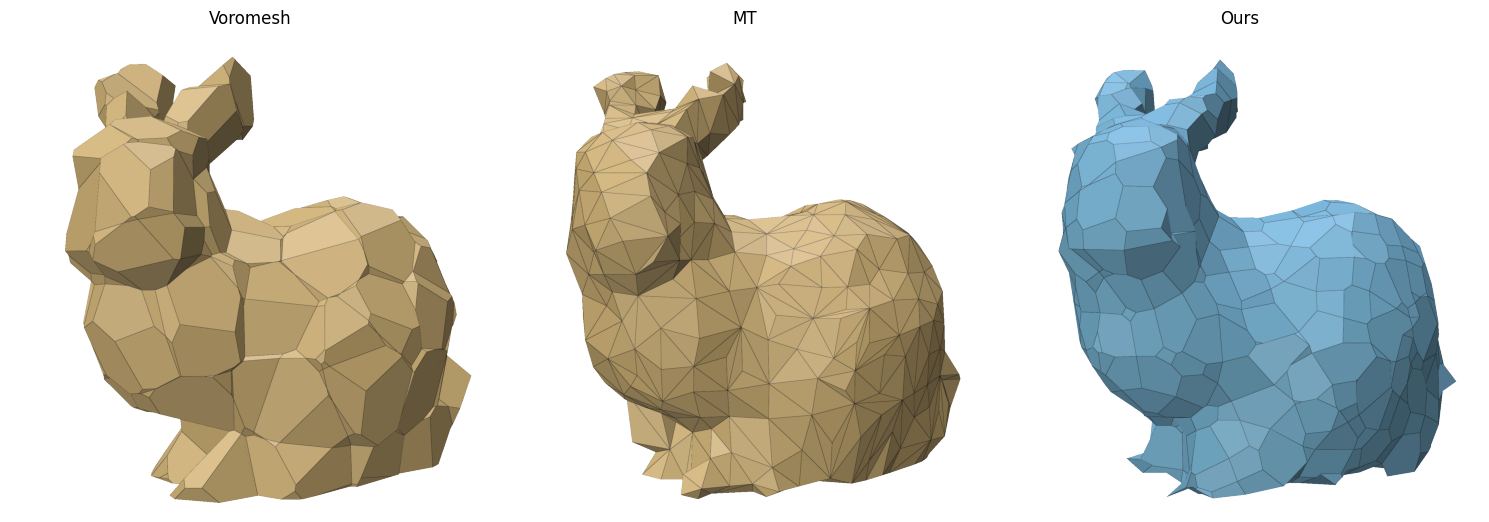

===== 32 ======
Voromesh FIGURE_CASE_441708/441708_b32/voromesh_32_final_DCCVT_cvt0_sdfsmooth0.obj
CD:1.837 | F1:0.66
MT FIGURE_CASE_441708/441708_b32/marching_tetrahedra_0_final_MT_cvt0_sdfsmooth0.obj
CD:2.804 | F1:0.559
Ours FIGURE_CASE_441708/441708_b32/DCCVT_0_final_intDCCVT_cvt100_sdfsmooth100.obj
CD:4.085 | F1:0.477


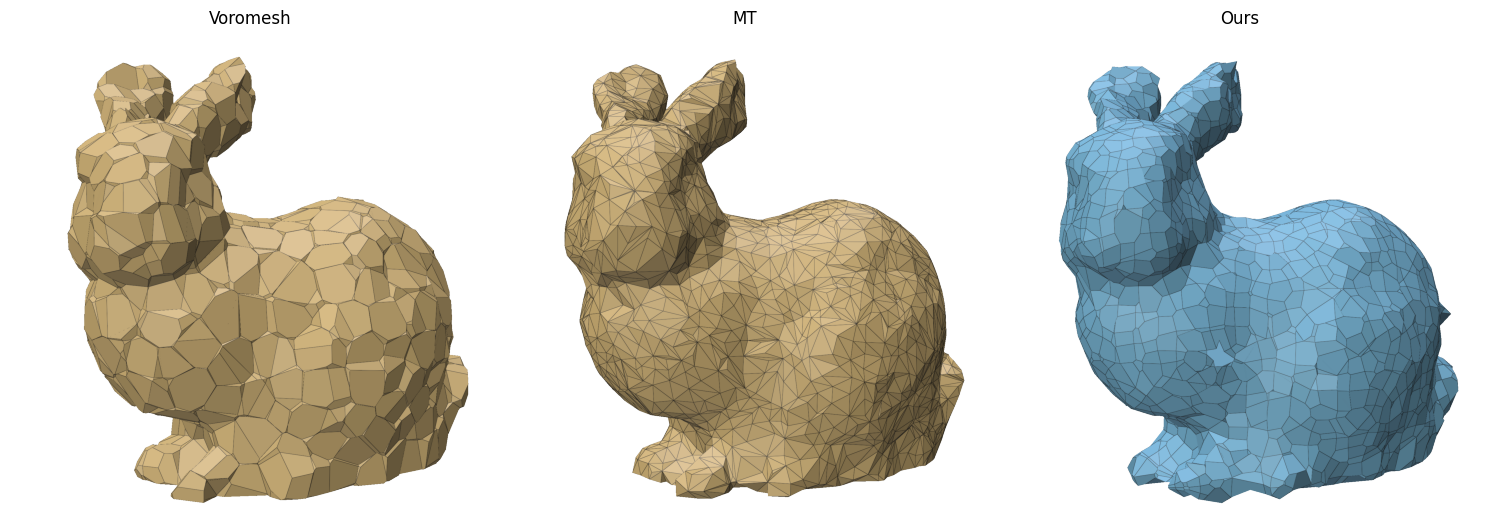

===== 64 ======
Voromesh FIGURE_CASE_441708/441708_b64/voromesh_64_final_DCCVT_cvt0_sdfsmooth0.obj
CD:3.221 | F1:0.565
MT FIGURE_CASE_441708/441708_b64/marching_tetrahedra_0_final_MT_cvt0_sdfsmooth0.obj
CD:1.96 | F1:0.724
Ours FIGURE_CASE_441708/441708_b64/DCCVT_0_final_intDCCVT_cvt100_sdfsmooth100.obj
CD:1.667 | F1:0.7


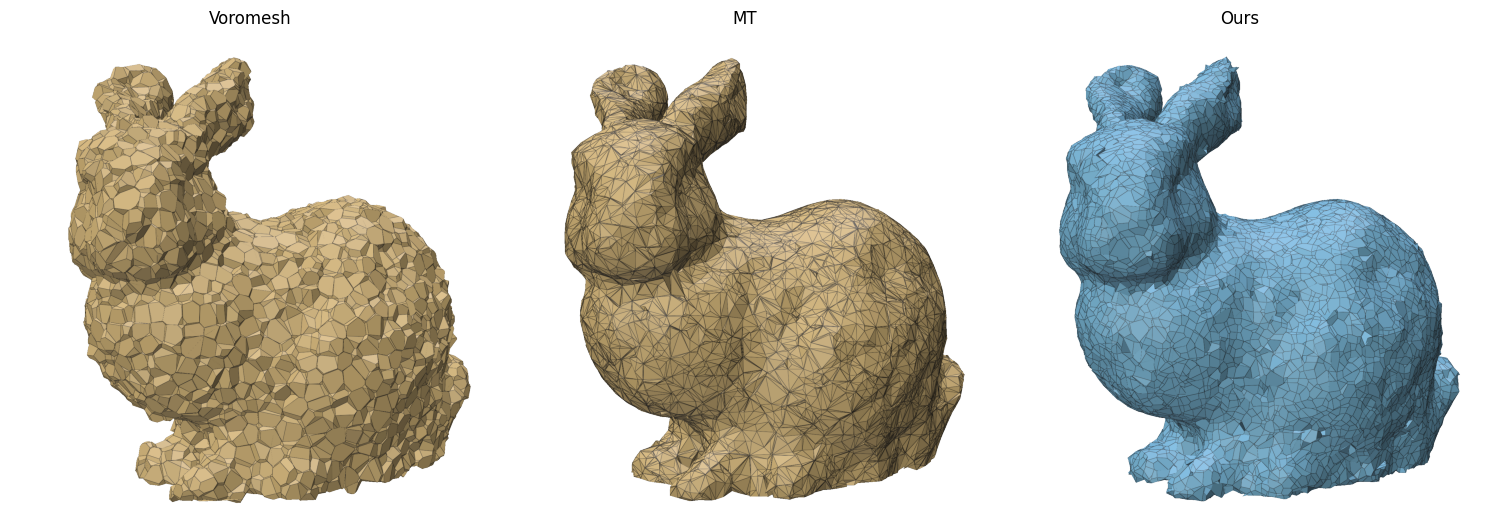

===== unconv32 ======
Voromesh FIGURE_CASE_441708/unconverged_441708_b32/voromesh_32_final_DCCVT_cvt0_sdfsmooth0.obj
CD:160.3 | F1:0.509
MT FIGURE_CASE_441708/unconverged_441708_b32/marching_tetrahedra_0_final_MT_cvt0_sdfsmooth0.obj
CD:3.173 | F1:0.552
Ours FIGURE_CASE_441708/unconverged_441708_b32/DCCVT_0_final_intDCCVT_cvt100_sdfsmooth100.obj
CD:5.175 | F1:0.484


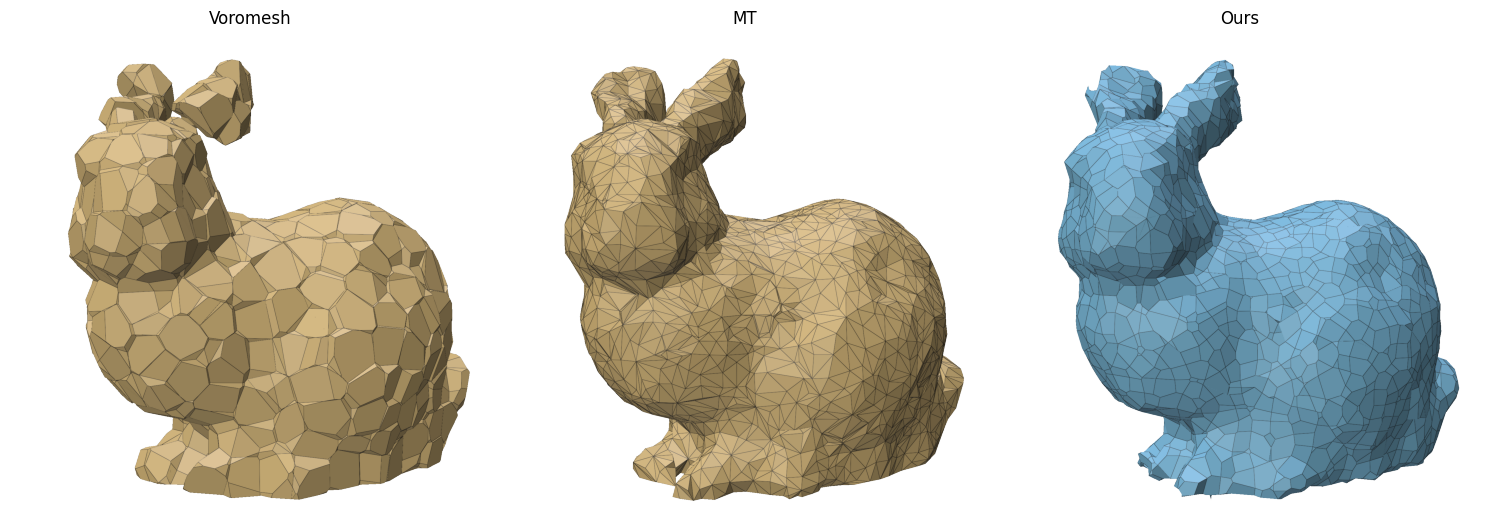

In [51]:
######### Global matrix
# ROOT = "FIGURE_CASE/"
# DIR = [("64764_b16", "16"), ("64764_b32", "32"), ("64764_b64", "64"), ("unconverged_64764_b32", "unconv32")]
ROOT = "FIGURE_CASE_441708/"
DIR = [("441708_b16", "16"), 
       ("441708_b32", "32"),
       ("441708_b64", "64"),
       ("unconverged_441708_b32", "unconv32")]
OUTPUT = "out/resolution/"
IMAGE_RES = (800, 800)
os.makedirs(OUTPUT, exist_ok=True)
ps.set_window_size(*IMAGE_RES)

errors_chamfer, errors_f1 = get_errors_from_csv(ROOT)

for dir in DIR:
    print(f"===== {dir[1]} ======")
    objs = glob.glob(ROOT + dir[0] + "/*.obj")
    # Remove all _init_ files
    objs = [f for f in objs if "_init_" not in f]
    # for obj in objs:
    #     print(f"- {obj}")

    selections = [("voromesh_", "Voromesh", COLOR_OTHER), ("marching_tetrahedra_0_final_MT_", "MT", COLOR_OTHER), ("DCCVT_0_final_intDCCVT", "Ours", COLOR_OURS)]

    # Create images based on the selection and OBJ list
    images = []
    for selection in selections:
        for obj in objs:
            if selection[0] in obj:
                img = obj2image(obj, aspect=IMAGE_RES[0]/IMAGE_RES[1], fov=27, cam_position=np.array([-1, -2, 0.1]), target=np.array([0, 0, -0.05]), color=selection[2])
                images.append((selection[1], img))

                # Load NPZ
                print(selection[1], obj)
                print(f"CD:{errors_chamfer[obj]*ERROR_SCALE:.4} | F1:{errors_f1[obj]:.3}")
                # print(f"Chamfer: {errors_chamfer[obj]:.2e} | F1: {errors_f1[obj]:.4e}")
    # Matplotlib all the image in matrix (only selection), no axis
    fig, axs = plt.subplots(1, len(selections), figsize=(15, 15))
    for i, (label, img) in enumerate(images):
        axs[i].imshow(img)
        axs[i].set_title(label)
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()

    # Save images
    for label, img in images:
        Image.fromarray(img).save(os.path.join(OUTPUT, f"{dir[1]}_{label}.png"))

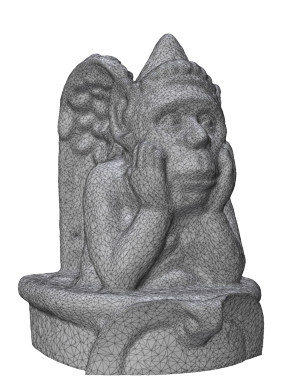

===== 32_unconv ======
MT FIGURE_CASE/unconverged_64764_b32/marching_tetrahedra_0_final_MT_cvt0_sdfsmooth0.obj
CD:10.09 | F1:0.248
Ours FIGURE_CASE/unconverged_64764_b32/DCCVT_0_final_intDCCVT_cvt100_sdfsmooth100.obj
CD:10.77 | F1:0.21
Voromesh FIGURE_CASE/unconverged_64764_b32/voromesh_32_final_DCCVT_cvt0_sdfsmooth0.obj
CD:86.02 | F1:0.275


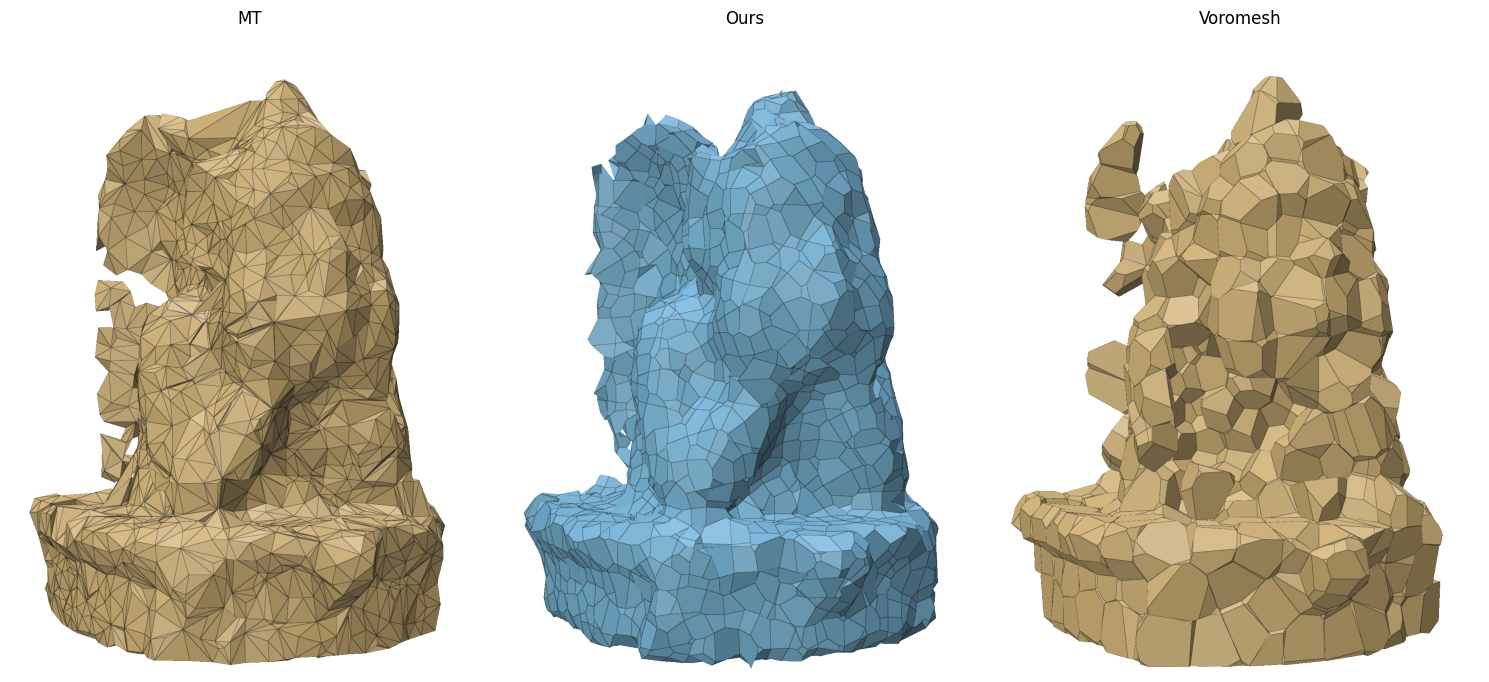

In [47]:
ROOT = "FIGURE_CASE/"
DIR = [("unconverged_64764_b32", "32_unconv")]
OUTPUT = "out/unconv/"
IMAGE_RES = (600, 800)
os.makedirs(OUTPUT, exist_ok=True)
ps.set_window_size(*IMAGE_RES)

errors_chamfer, errors_f1 = get_errors_from_csv(ROOT)

# Reference
obj = "../mesh/thingi32/64764.obj"
img = obj2image(obj, aspect=IMAGE_RES[0]/IMAGE_RES[1], fov=30, cam_position=np.array([-1.0, -2.0, 0.0]), rescale=True, color=COLOR_REF)
Image.fromarray(img).save(os.path.join(OUTPUT, f"ref.png"))
plt.imshow(img)
plt.axis("off")
plt.show()

for dir in DIR:
    print(f"===== {dir[1]} ======")
    objs = glob.glob(ROOT + dir[0] + "/*.obj")
    # Remove all _init_ files
    objs = [f for f in objs if "_init_" not in f]
    # for obj in objs:
    #      print(f"- {obj}")

    selections = [("marching_tetrahedra_0_final_MT_", "MT", COLOR_OTHER), ("DCCVT_0_final_intDCCVT", "Ours", COLOR_OURS), ("voromesh_", "Voromesh", COLOR_OTHER)]
    if "nearup" == dir[1] or "nearup_unconv" == dir[1] or "up_unconv" == dir[1] or "up" == dir[1]:
        selections = [("marching_tetrahedra_10_final_MT_", "MT", COLOR_OTHER), ("DCCVT_10_final_intDCCVT", "Ours", COLOR_OURS)]
    # print(selections)
    # Create images based on the selection and OBJ list
    images = []
    for selection in selections:
        for obj in objs:
            if selection[0] in obj:
                img = obj2image(obj, aspect=IMAGE_RES[0]/IMAGE_RES[1], fov=30, cam_position=np.array([-1.0, -2.0, 0.0]), color=selection[2])
                images.append((selection[1], img))

                # Load NPZ
                print(selection[1], obj)
                print(f"CD:{errors_chamfer[obj]*ERROR_SCALE:.4} | F1:{errors_f1[obj]:.3}")
                # print(f"CD:{errors_chamfer[obj]:.2e} | F1:{errors_f1[obj]:.2e}")
    # Matplotlib all the image in matrix (only selection), no axis
    fig, axs = plt.subplots(1, len(selections), figsize=(15, 15))
    for i, (label, img) in enumerate(images):
        axs[i].imshow(img)
        axs[i].set_title(label)
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()

    # Save images
    for label, img in images:
        Image.fromarray(img).save(os.path.join(OUTPUT, f"{dir[1]}_{label}.png"))

===== near_unconv ======
MT FIGURE_CASE/unconverged_64764_b32_nearsample/marching_tetrahedra_0_final_MT_cvt0_sdfsmooth0.obj
CD:14.12 | F1:0.293
Ours FIGURE_CASE/unconverged_64764_b32_nearsample/DCCVT_0_final_intDCCVT_cvt100_sdfsmooth100.obj
CD:3.593 | F1:0.359


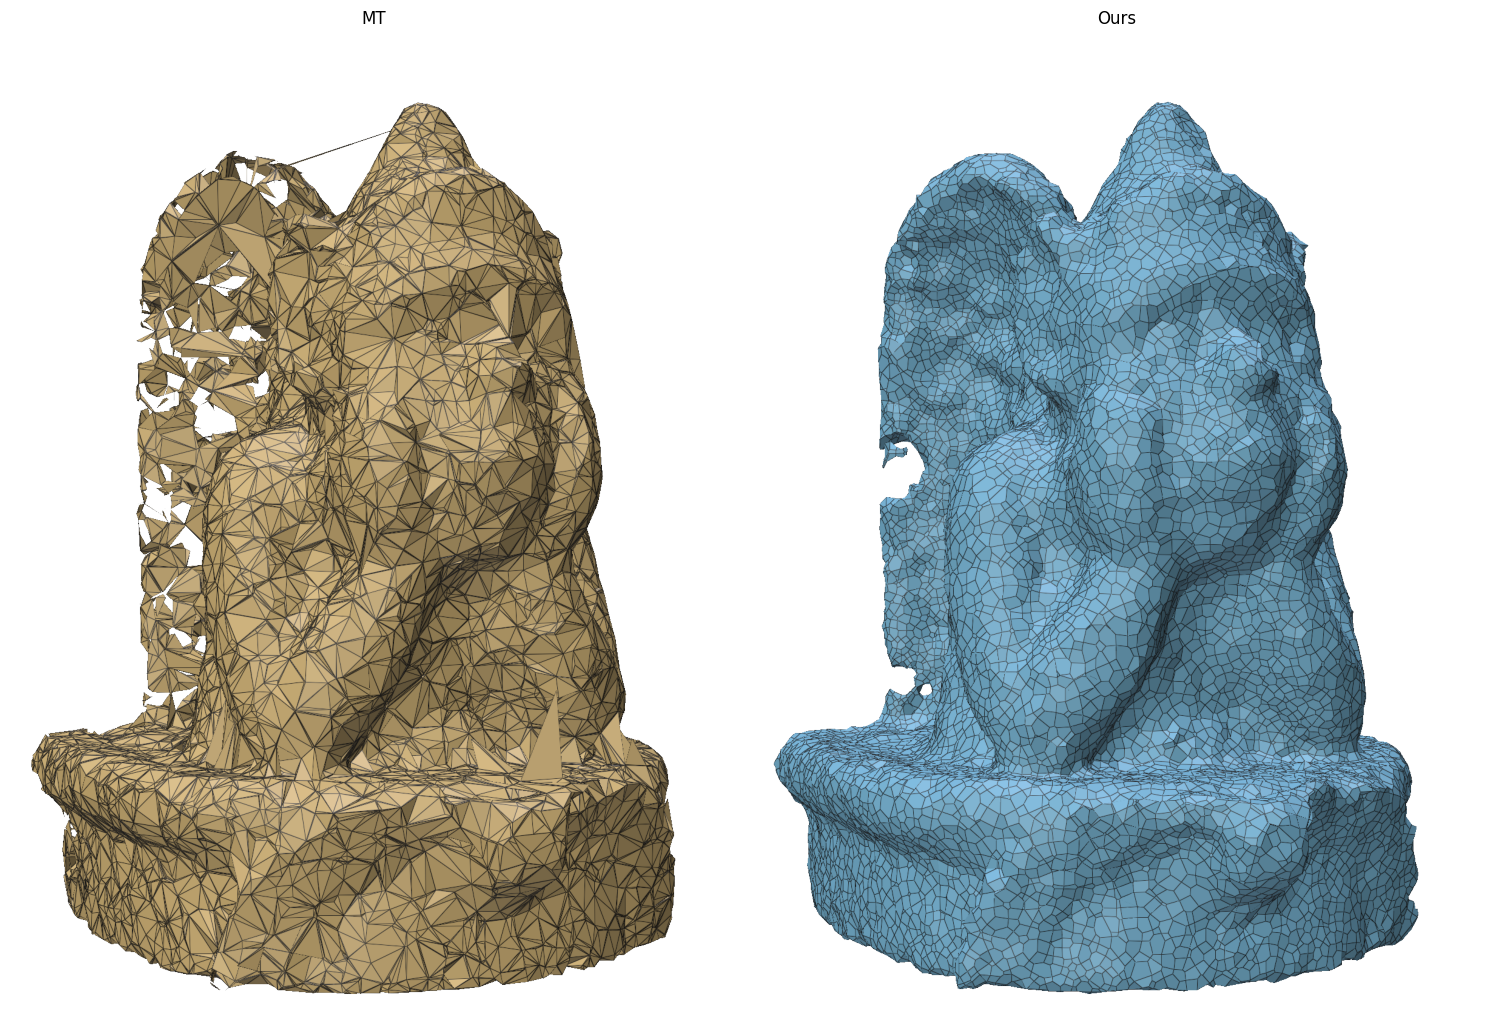

===== up_unconv ======
MT FIGURE_CASE/unconverged_64764_b32_ups/marching_tetrahedra_10_final_MT_cvt0_sdfsmooth0.obj
CD:3.568 | F1:0.368
Ours FIGURE_CASE/unconverged_64764_b32_ups/DCCVT_10_final_intDCCVT_cvt100_sdfsmooth100.obj
CD:3.704 | F1:0.345


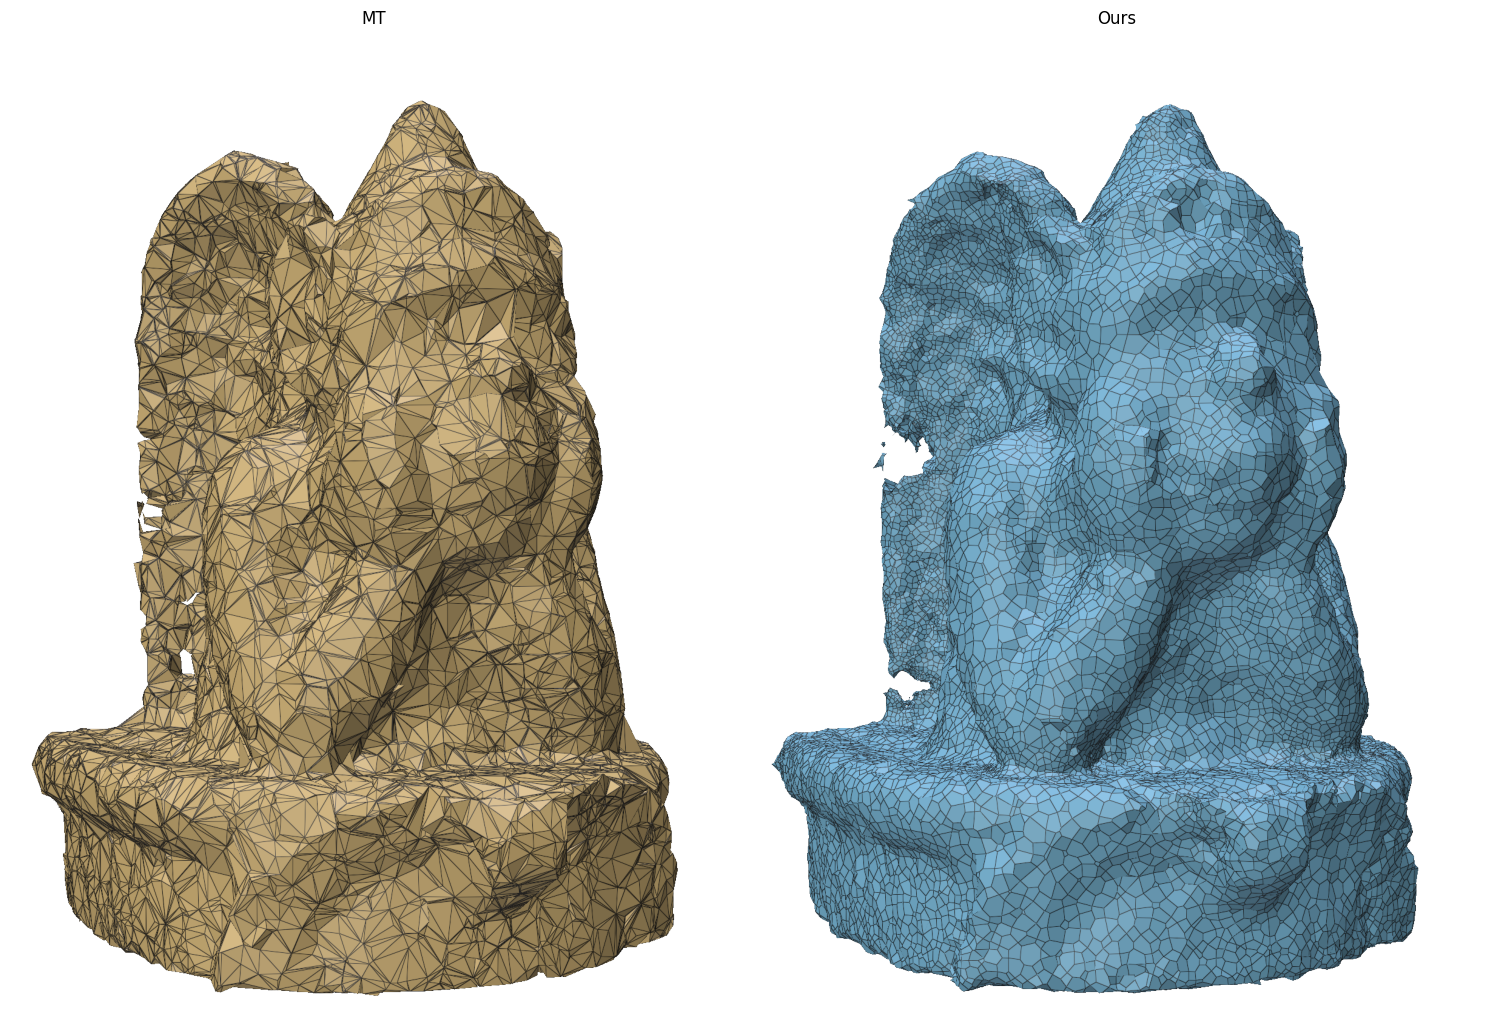

===== nearup_unconv ======
MT FIGURE_CASE/unconverged_64764_b32_nearsample_ups_4096/marching_tetrahedra_10_final_MT_cvt0_sdfsmooth0.obj
CD:10.16 | F1:0.322
Ours FIGURE_CASE/unconverged_64764_b32_nearsample_ups_4096/DCCVT_10_final_intDCCVT_cvt100_sdfsmooth100.obj
CD:3.421 | F1:0.352


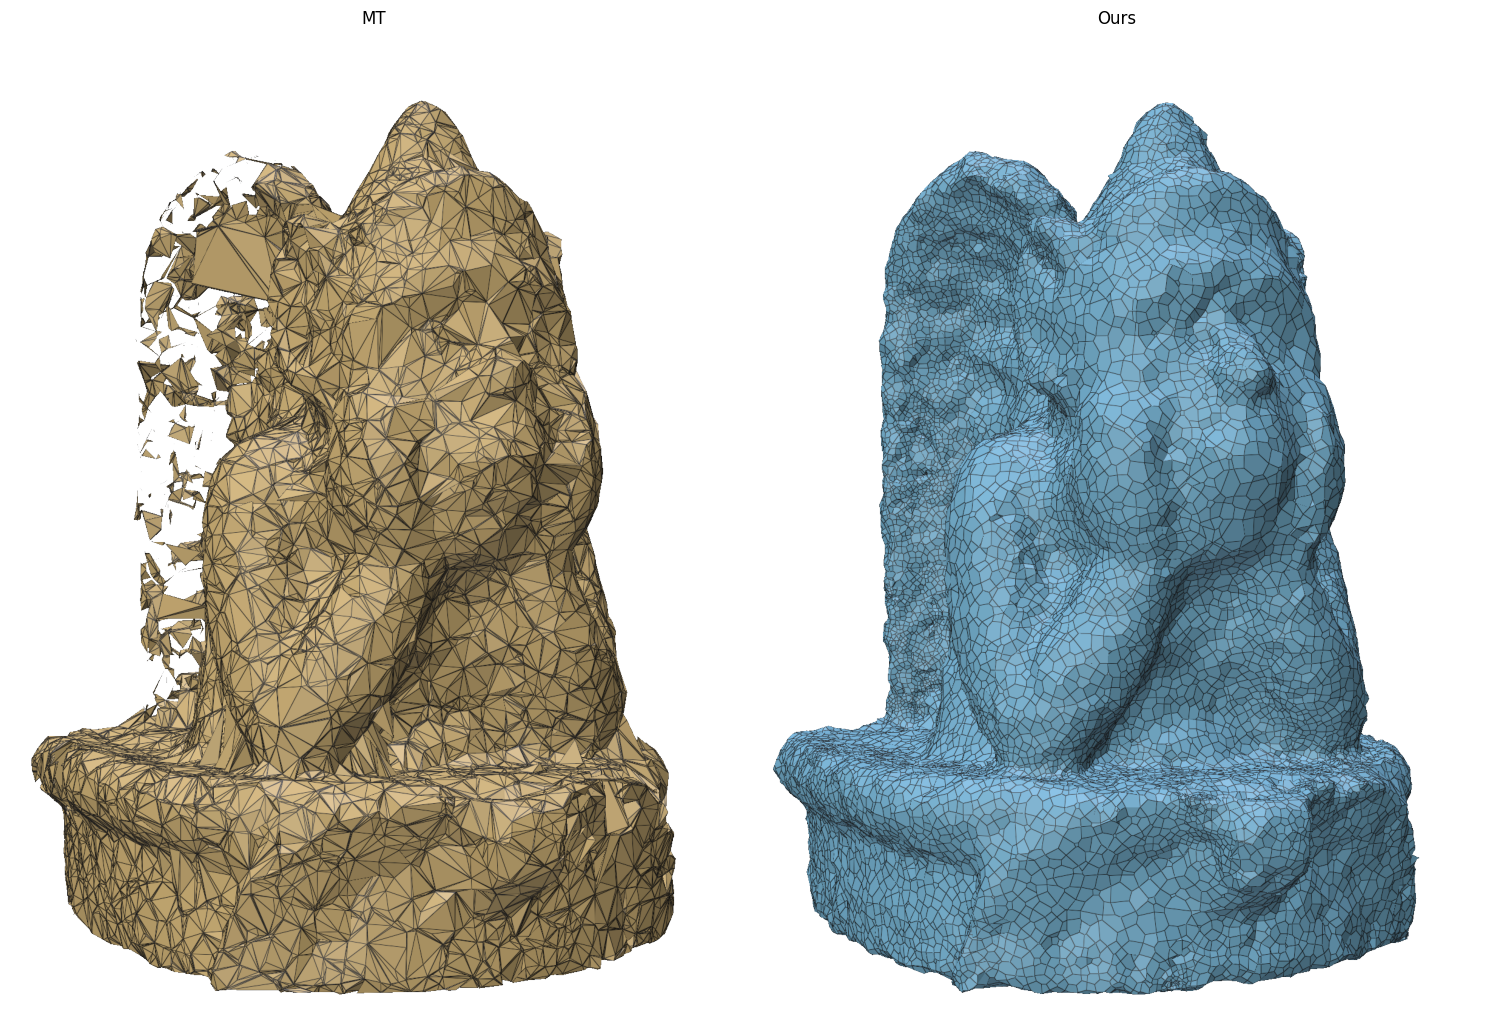

In [55]:
ROOT = "FIGURE_CASE/"
DIR = [
    #    ("64764_b32", "32"),
    #    ("64764_b32_ups", "up"), 
    #    ("64764_b32_nearsample_18944", "near"), 
    #    ("64764_b32_nearsample_ups_4096", "nearup"), 
       ("unconverged_64764_b32_nearsample", "near_unconv"), 
       ("unconverged_64764_b32_ups", "up_unconv"), 
       ("unconverged_64764_b32_nearsample_ups_4096", "nearup_unconv")]
OUTPUT = "out/upsampling/"
IMAGE_RES = (600, 800)
os.makedirs(OUTPUT, exist_ok=True)
ps.set_window_size(*IMAGE_RES)

errors_chamfer, errors_f1 = get_errors_from_csv(ROOT)

for dir in DIR:
    print(f"===== {dir[1]} ======")
    objs = glob.glob(ROOT + dir[0] + "/*.obj")
    # Remove all _init_ files
    objs = [f for f in objs if "_init_" not in f]
    # for obj in objs:
    #      print(f"- {obj}")

    selections = [("marching_tetrahedra_0_final_MT_", "MT", COLOR_OTHER), ("DCCVT_0_final_intDCCVT", "Ours", COLOR_OURS)]
    if "nearup" == dir[1] or "nearup_unconv" == dir[1] or "up_unconv" == dir[1] or "up" == dir[1]:
        selections = [("marching_tetrahedra_10_final_MT_", "MT", COLOR_OTHER), ("DCCVT_10_final_intDCCVT", "Ours", COLOR_OURS)]
    # print(selections)
    # Create images based on the selection and OBJ list
    images = []
    for selection in selections:
        for obj in objs:
            if selection[0] in obj:
                img = obj2image(obj, aspect=IMAGE_RES[0]/IMAGE_RES[1], fov=30, cam_position=np.array([-1.0, -2.0, 0.0]), color=selection[2])
                images.append((selection[1], img))

                # Load NPZ
                print(selection[1], obj)
                print(f"CD:{errors_chamfer[obj]*ERROR_SCALE:.4} | F1:{errors_f1[obj]:.3}")
                # print(f"CD:{errors_chamfer[obj]:.2e} | F1:{errors_f1[obj]:.2e}")
    # Matplotlib all the image in matrix (only selection), no axis
    fig, axs = plt.subplots(1, len(selections), figsize=(15, 15))
    for i, (label, img) in enumerate(images):
        axs[i].imshow(img)
        axs[i].set_title(label)
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()

    # Save images
    for label, img in images:
        Image.fromarray(img).save(os.path.join(OUTPUT, f"{dir[1]}_{label}.png"))

31 errors for Voro.
Voro.:	 Avg CD=12.5670, 	Avg F1=0.3831
31 errors for MT
MT:	 Avg CD=7.5167, 	Avg F1=0.3097
31 errors for Ours
Ours:	 Avg CD=11.1193, 	Avg F1=0.2679


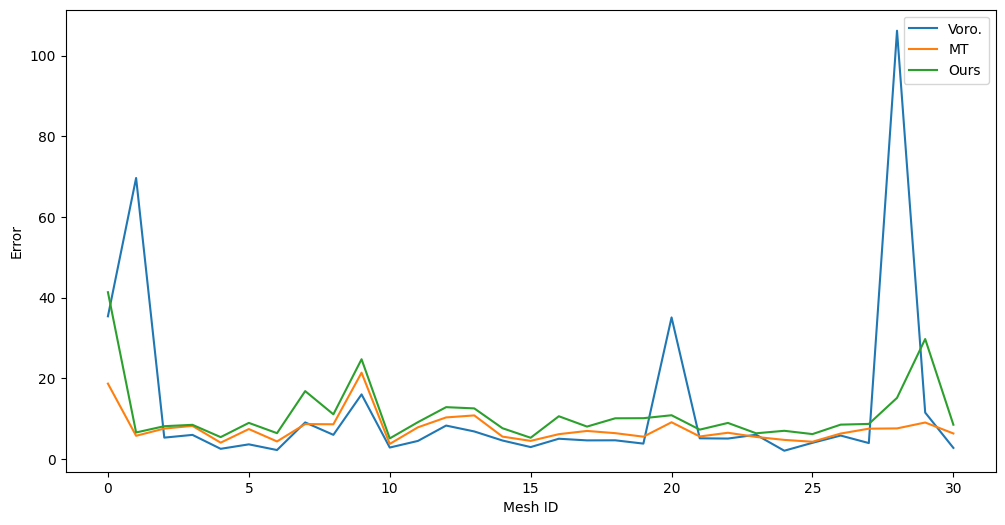

0 errors for Ours


ZeroDivisionError: division by zero

In [ ]:


# Show all error one line
# for k in selected_chamfer:
#     print(f"{k}: CD={selected_chamfer[k]:.4f}, F1={selected_f1[k]:.4f}")

def show_stats(selected_chamfer, selected_f1, selctions):
    sel_error_chamfer = {}
    sel_error_f1 = {}
    for sel in selections:
        sel_error_chamfer[sel[1]] = []
        sel_error_f1[sel[1]] = []
        for k in selected_chamfer:
            if sel[0] in k:
                # print(f"{k}: CD={selected_chamfer[k]*ERROR_SCALE:.4f}, F1={selected_f1[k]:.4f}")
                sel_error_chamfer[sel[1]].append(selected_chamfer[k]*ERROR_SCALE)
                sel_error_f1[sel[1]].append(selected_f1[k])

    # Compute average
    for sel in selections:
        print(len(sel_error_chamfer[sel[1]]), "errors for", sel[1])
        avg_chamfer = sum(sel_error_chamfer[sel[1]]) / len(sel_error_chamfer[sel[1]])
        avg_f1 = sum(sel_error_f1[sel[1]]) / len(sel_error_f1[sel[1]])
        print(f"{sel[1]}:\t Avg CD={avg_chamfer:.4f}, \tAvg F1={avg_f1:.4f}")


    # Show curves of the Chamfer distance with mesh ID
    plt.figure(figsize=(12, 6))
    for sel in selections:
        plt.plot(sel_error_chamfer[sel[1]], label=sel[1])
    plt.xlabel('Mesh ID')
    plt.ylabel('Error')
    plt.legend()
    plt.show()

errors_chamfer, errors_f1 = get_errors_from_csv("ALL/")

# Select all b32
selections = [("voromesh_", "Voro.", COLOR_OTHER), ("marching_tetrahedra_0_final_MT_", "MT", COLOR_OTHER), ("DCCVT_0_final_intDCCVT", "Ours", COLOR_OURS)]
selected_chamfer = {k: v for k, v in errors_chamfer.items() if "_b32/" in k}
selected_f1 = {k: v for k, v in errors_f1.items() if "_b32/" in k}
show_stats(selected_chamfer, selected_f1, selections)

# ("marching_tetrahedra_10_final_MT_", "MT", COLOR_OTHER),
selections = [ ("DCCVT_10_final_intDCCVT", "Ours", COLOR_OURS)]
selected_chamfer = {k: v for k, v in errors_chamfer.items() if "_b32_ups/" in k}
selected_f1 = {k: v for k, v in errors_f1.items() if "_b32_ups/" in k}
show_stats(selected_chamfer, selected_f1, selections)